# Measurement uncertainty calculations

# Introduction

### Definitions
**Measurement uncertainty** is defined in the ISO ‘Guide to the Expression of Uncertainty in Measurement’ as ‘a parameter, associated with the result of a measurement that characterises the dispersion of the values that  could  reasonably  be  attributed  to  the  measurand’.  The  **measurand**  is  the  ‘quantity  intended  to  be measured’.

### Purpose
An estimate  of  uncertainty  provides  a  quantitative  indication  of  the  quality  of  a  measurement  result. Rather than using a ‘bottom-up’ approach which examines the inputs to a method and considers how they might influence results, the biochemical genetics units uses a ‘top-down’ approach using the information from method outputs (e.g. the observed variability of replicate measurement results), as described in ADD.BIO 6680: Estimating measurement uncertainty in the biochemical genetics unit. This notebook attempts to outline these steps.

## Imports, configuration

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Since some columns have long names, change the maximum column width in Pandas so we can see the full name.

In [3]:
pd.set_option('display.max_colwidth', -1)

C:\Users\nickf\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


## Import mappings

The mappings file contains:
* mappings to link the Assay and Measurand to the name of the QC material in [Randox Acusera 24:7](https://qc.randox.com/Acusera#Home)
* the lower and upper limit of quantitation, as described in the assay SOP. If the lower or upper limits are not specified in the SOP, these are given as 0 and 9999999 respectively. If more than one limit is provided (for example, different limits for different instruments), then the lower lower limit or higher upper limit was used.

In [ ]:
mappings = pd.read_csv('data\\raw_data\\mappings.csv')
mappings.head()

# Obtain an estimate of the precision of the measurement procedure

## Import measurement uncertainty report from Randox Acusera 24:7

The measurement uncertainty report contains stiastics on each lot number in Randox Acusera. Data points that have been rejected are not included in the analysis.

when importing the data, exclude QC lots where the measurand concentration is outside the reportable range

In [ ]:
def import_randox(filename, mappings):
    '''
    Imports measurement uncertainty excel file from Randox Acusera, then
    maps these to the Assay and Measurands via the Mappings file
    
    Drops any statistics for QCs that are below the limit of quantitation
    (if defined in the mappings file)
    '''
    randoxMU = pd.read_excel(filename)
    randoxMU = randoxMU.rename(columns={'Assay':'Randox'})
    randoxMU = randoxMU.drop(columns=['Intra','Inter','ExpandedUOM'])
    randoxMU = randoxMU.sort_values(by=['Randox','Mean'])
    

    
    ## Calculate the percentage CV
    randoxMU['% CV'] = round(randoxMU['UOM']/randoxMU['Mean'] * 100,1)
    
    ## Urine, Plasma and CSF QCs are all stored in Randox under the same name.
    ## Add an extra note in the Randox column for urine QC to distinguish these,
    ## identified by the lot number starting with "AAU"
    randoxMU['Randox'][randoxMU['Lot Name'].str[:3] == 'AAU'] = randoxMU['Randox'].astype(str) + ' (Urine)'
    
    ## Read the mappings csv file and join this with the QC data to show the Assay and Measurand name, and import LoQ
    mappings = pd.read_csv(mappings)
    qc_data = mappings.merge(right=randoxMU,on='Randox',how='inner')
    
    ## Drop any QC values that are outside the reportable interval
    qc_data = qc_data.query('Mean >= reportable_range_lower')
    qc_data = qc_data.query('Mean <= reportable_range_upper')
    
    return qc_data

In [ ]:
qc_data = import_randox("data\\raw_data\\Uncertainty of Measurement.xlsx"
                        ,"data\\raw_data\\mappings.csv")

In [ ]:
qc_data.head()

## Obtain an estimate of the precision of the measurement procedure

The measurement uncertainty report from Randox needs to be processed to:
* exclude QC lots where the measurand concentration is outside the reportable range (done above when importing the data)
* exclude QC lots with low counts
* calculate averages for each measurand
* present the data by assay in a useful format

First,  create a summary for each lot number that shows some basic statistics by pivoting existing data and removing lots with low counts.

In [ ]:
def qc_lot_summary(qc_data, assay, count_thresh=1):
    '''
    Returns a dataframe containing lot number statistics for the assay QC data
    Excludes any statistics with fewer than count_thresh values
    '''
    ## Define the order in which columns should appear
    column_order = ['Count','Mean','UOM','% CV']
    
    ## Filter the main qc data file for only the assay we are interested in, and drop unnecessary columns
    assay_qc_data = qc_data[qc_data['Assay'] == assay].drop(columns=['Assay','Randox'])
    
    ## Drop any QC values where there are fewer than count_thresh datapoints
    assay_qc_data = assay_qc_data[assay_qc_data['Count'] >= count_thresh]
    
    ## Round the data to 2 decimal places
    assay_qc_data = assay_qc_data.round(2)
    
    ## Pivot the data and reorder levels
    assay_qc_pivot = assay_qc_data.pivot(index='Measurand', values=column_order, columns=['Lot Name','Instrument'])
    assay_qc_pivot = assay_qc_pivot.swaplevel(0,2, axis=1).sort_index(axis=1)

    ## Reorder columns and fill blanks
    assay_qc_pivot = assay_qc_pivot.reindex(column_order, level=2, axis=1)
    assay_qc_pivot = assay_qc_pivot.fillna('')
    
    return assay_qc_pivot

In [ ]:
qc_lot_summary(qc_data,'Organic acids', 10)

Next, we aggregate the data over all lots numbers and instruments (excluding those whe the count is less than the count threshold) by summing the total counts and averaging the measurement uncertainty and %CV.

In [ ]:
def qc_aggregated(qc_data, assay, count_thresh=1):
    '''
    Returns total number of QC datapoints for each analyte and average of each lot number measurement uncertainty and %CV
    Excludes any statistics with fewer than count_thresh values
    '''
    filtered = qc_data[qc_data['Assay'] == assay].drop(columns=['Assay','Randox'])
    filtered = filtered[filtered['Count'] >= count_thresh]
    aggregated = filtered.groupby('Measurand').agg({'Count':'sum',
                                              'UOM':'mean',
                                              '% CV':'mean'})
    return aggregated.round(2)

In [ ]:
qc_aggregated(qc_data,'Organic acids',10)

We can then combine the lot statistics and aggregated statistics.

Previously, this has been only done if the %CV are similar for each lot. However, for simplicity, average across all lots, regardless of differences in imprecision at different concentrations

In [ ]:
def qc_lot_summary_with_means(qc_data, assay, count_thresh=1):
    '''
    Returns a dataframe containing both lot number statistics and aggregated statistics
    Excludes any statistics with fewer than count_thresh values
    '''
    assay_qc_pivot = qc_lot_summary(qc_data, assay, count_thresh)
    aggregated = qc_aggregated(qc_data, assay, count_thresh)
    
    assay_qc_pivot[('All instrument','All lots','Count')] = aggregated['Count']
    assay_qc_pivot[('All instrument','All lots','UOM')] = aggregated['UOM']
    assay_qc_pivot[('All instrument','All lots','% CV')] = aggregated['% CV']
    
    return assay_qc_pivot.round(2)

In [ ]:
qc_lot_summary_with_means(qc_data, 'Amino acids (Plasma)', 10)

Note: for the acylcarnitines assay, some measurands have data for one QC lot, and some measurands do not appear at all. This is because the measurand is present at less than the limit of quantitation

In [ ]:
qc_lot_summary_with_means(qc_data, 'Acylcarnitines (Blood spot)', 10)

We can export the data for all assays as seperate .csv files which are saved in the \data\processed\qc_summary_tables folder

In [ ]:
def assay_qc_data_export(df, count_thresh):
    '''
    Createsa a qc summary table for each assay (excluding any statistics
    with fewer than count_thresh value per lot number / instrument.
    
    Exports each table to a .csv file in the processed data folder
    '''
    for assay in df['Assay'].unique():
        try:
            filepath = os.path.abspath('') + '\\data\\processed\\qc_summary_tables\\' + assay + '.csv'
            table = qc_lot_summary_with_means(df, assay, count_thresh)
            table.to_csv(filepath)
            print(f'{assay} succesfully exported')
        except:
            print(f'!!! Error in exporting data for {assay}')

In [ ]:
assay_qc_data_export(qc_data,10)

# Obtain an estimate of the measurement bias and its uncertainty

Measurement bias and its uncertainty can be estimnated from the regular participation in external quality assessment (EQA).

Import EQA results from a csv file (UKNEQAS results can be obtained using EQA data scraper)

In [4]:
eqa_results = pd.read_csv('data\\raw_data\\eqa_results.csv')

In [5]:
eqa_results.head()

,Analyte,Specimen,Pool,Result,Targ,Scheme name
0,Phenylalanine,209A,273,137,142.1,Quantitative Amino Acids
1,Phenylalanine,209B,274,1373,1314.0,Quantitative Amino Acids
2,Phenylalanine,209C,275,960,911.3,Quantitative Amino Acids
3,Tyrosine,209A,273,99,101.8,Quantitative Amino Acids
4,Tyrosine,209B,274,202,197.7,Quantitative Amino Acids


## Plot bias against Target values

The EQA data does not contain the specimen bias. We can calculate this from the result and target value (after excluding non-numeric results and target values)

In [6]:
def eqa_bias(df):
    # Remove rows with non-numeric result or target values
    # https://stackoverflow.com/questions/21771133/finding-non-numeric-rows-in-dataframe-in-pandas/44178063
    data_columns = ['Result','Targ']
    num_df = (df.drop(data_columns, axis=1)
         .join(df[data_columns].apply(pd.to_numeric, errors='coerce')))

    num_df = num_df[num_df[data_columns].notnull().all(axis=1)]
    
    ##Calculate percentage bias
    num_df['% Bias'] = round(100*(num_df['Result'] - num_df['Targ'])/num_df['Targ'],1)
    return num_df

In [7]:
eqa_bias_df = eqa_bias(eqa_results)
eqa_bias_df

,Analyte,Specimen,Pool,Scheme name,Result,Targ,% Bias
0,Phenylalanine,209A,273,Quantitative Amino Acids,137.0,142.1,-3.6
1,Phenylalanine,209B,274,Quantitative Amino Acids,1373.0,1314.0,4.5
2,Phenylalanine,209C,275,Quantitative Amino Acids,960.0,911.3,5.3
3,Tyrosine,209A,273,Quantitative Amino Acids,99.0,101.8,-2.8
4,Tyrosine,209B,274,Quantitative Amino Acids,202.0,197.7,2.2
...,...,...,...,...,...,...,...
367,HVA,246B,C402,Urinary Catecholamines & Metabolite,58.8,61.5,-4.4
368,HVA,246C,C403,Urinary Catecholamines & Metabolite,16.5,17.6,-6.3
369,5HIAA,246A,C401,Urinary Catecholamines & Metabolite,22.0,23.2,-5.2
370,5HIAA,246B,C402,Urinary Catecholamines & Metabolite,84.0,89.0,-5.6


Next plot the data to see if bias varies with target value. This can be done either individually, or for all schemes in the EQA data.

First plot for a single EQA scheme:

In [10]:
def eqa_bias_plot(eqa_bias, scheme):
    '''
    Plot %bias against target value for all analytes in a single scheme
    '''
    eqa_bias = eqa_bias[eqa_bias['Scheme name'] == scheme]    
    
    g = sns.FacetGrid(data=eqa_bias, col='Analyte', col_wrap=5, sharex=False)
    g = g.map(plt.scatter, "Targ", "% Bias", edgecolor="w")
    g.fig.suptitle(f'EQA results: {scheme}', ha='left', x=0, weight='bold')
    g.fig.subplots_adjust(top=0.8)

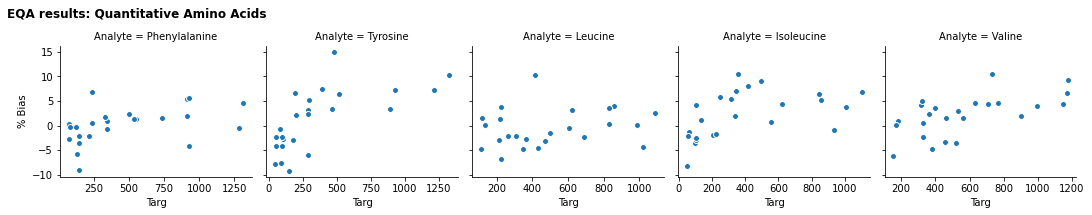

In [11]:
eqa_bias_plot(eqa_bias_df,'Quantitative Amino Acids')

Next, plot for all schemes in the eqa data

In [12]:
def eqa_bias_multi_plot(df):
    '''
    Plot % bias against target value for all analytes in ALL schemes in a dataframe df
    '''
    for scheme in df['Scheme name'].unique():
        eqa_bias_plot(df, scheme)

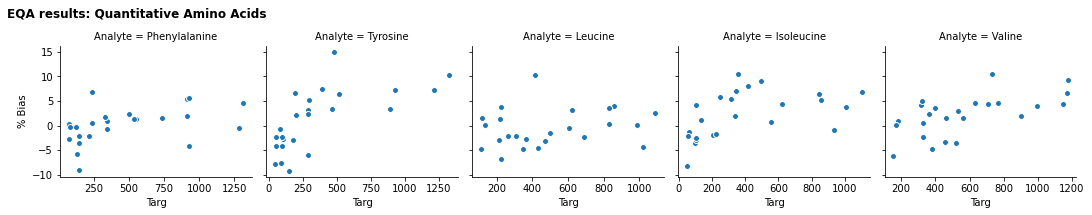

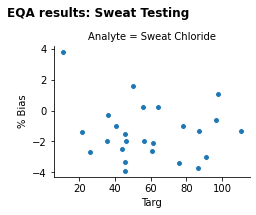

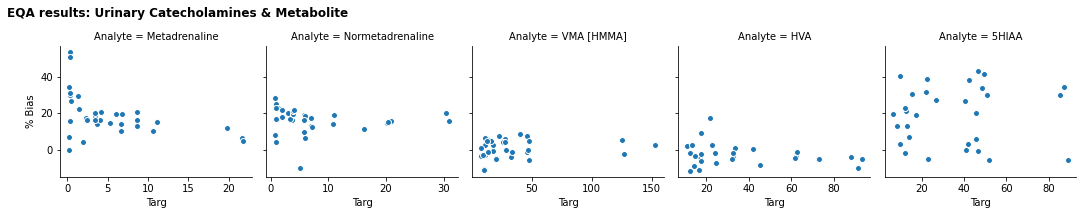

In [13]:
eqa_bias_multi_plot(eqa_bias_df)

## Calculate the mean bias and standard deviation of the mean bias

In [22]:
eqa_bias_df

,Analyte,Specimen,Pool,Scheme name,Result,Targ,% Bias
0,Phenylalanine,209A,273,Quantitative Amino Acids,137.0,142.1,-3.6
1,Phenylalanine,209B,274,Quantitative Amino Acids,1373.0,1314.0,4.5
2,Phenylalanine,209C,275,Quantitative Amino Acids,960.0,911.3,5.3
3,Tyrosine,209A,273,Quantitative Amino Acids,99.0,101.8,-2.8
4,Tyrosine,209B,274,Quantitative Amino Acids,202.0,197.7,2.2
...,...,...,...,...,...,...,...
367,HVA,246B,C402,Urinary Catecholamines & Metabolite,58.8,61.5,-4.4
368,HVA,246C,C403,Urinary Catecholamines & Metabolite,16.5,17.6,-6.3
369,5HIAA,246A,C401,Urinary Catecholamines & Metabolite,22.0,23.2,-5.2
370,5HIAA,246B,C402,Urinary Catecholamines & Metabolite,84.0,89.0,-5.6


In [21]:
eqa_bias_df.groupby(['Scheme name','Analyte']).agg({'% Bias':['mean','std']})

% Bias           
                                                           mean        std
Scheme name                         Analyte                               
Quantitative Amino Acids            Isoleucine        2.283333   4.764239 
                                    Leucine          -0.483333   3.830049 
                                    Phenylalanine     0.133333   3.658661 
                                    Tyrosine          1.258333   6.285934 
                                    Valine            2.191667   4.117293 
Sweat Testing                       Sweat Chloride   -1.438462   1.776306 
Urinary Catecholamines & Metabolite 5HIAA             19.213333  15.902347
                                    HVA              -2.946667   5.850949 
                                    Metadrenaline     18.854545  11.664907
                                    Normetadrenaline  16.075758  6.986596 
                                    VMA [HMMA]        0.600000   4.997437

### Standard uncertainty in the target value

In [25]:
def standard_uncertainty_data(filename):
    df = pd.read_csv(filename)
    standard_uncertainty = df[df['Name'] == 'Standard Uncertainty']
    
    #Assumes that there are three samples per distribution for all schemes (might be dangerous)
    standard_uncertainty['Distribution'][0::3] = standard_uncertainty['Distribution'][0::3].astype(str) + 'A'
    standard_uncertainty['Distribution'][1::3] = standard_uncertainty['Distribution'][1::3].astype(str) + 'B'
    standard_uncertainty['Distribution'][2::3] = standard_uncertainty['Distribution'][2::3].astype(str) + 'C'
    
    standard_uncertainty = standard_uncertainty.rename(columns={'Analyte name':'Analyte','Distribution':'Specimen'})
    
    return standard_uncertainty

In [26]:
std_uncert = standard_uncertainty_data('data\\raw_data\\EQA_analyte_information.csv')

C:\Users\nickf\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\nickf\Anaconda3\lib\site-packages\pandas\core\series.py:1027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_with(key, value)
C:\Users\nickf\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [28]:
std_uncert.head()

,Name,Value,Analyte,Specimen,Scheme name
3,Standard Uncertainty,1.2,Initial TSH (mU/L WB),321A,Birmingham Quality ~ Newborn British Isles
13,Standard Uncertainty,1.1,Initial TSH (mU/L WB),321B,Birmingham Quality ~ Newborn British Isles
23,Standard Uncertainty,1.6,Initial TSH (mU/L WB),321C,Birmingham Quality ~ Newborn British Isles
33,Standard Uncertainty,0.8,Final TSH (mU/L WB),321A,Birmingham Quality ~ Newborn British Isles
43,Standard Uncertainty,0.7,Final TSH (mU/L WB),321B,Birmingham Quality ~ Newborn British Isles


In [33]:
eqa_bias_df.merge(right=std_uncert,on=['Analyte','Specimen','Scheme name'],how='outer')

,Analyte,Specimen,Pool,Scheme name,Result,Targ,% Bias,Name,Value
0,Phenylalanine,209A,273,Quantitative Amino Acids,137.0,142.1,-3.6,NaN,NaN
1,Phenylalanine,209B,274,Quantitative Amino Acids,1373.0,1314.0,4.5,NaN,NaN
2,Phenylalanine,209C,275,Quantitative Amino Acids,960.0,911.3,5.3,NaN,NaN
3,Tyrosine,209A,273,Quantitative Amino Acids,99.0,101.8,-2.8,NaN,NaN
4,Tyrosine,209B,274,Quantitative Amino Acids,202.0,197.7,2.2,NaN,NaN
...,...,...,...,...,...,...,...,...,...
372,HVA (umol/24h),246B,NaN,Urinary Catecholamines & Metabolite,NaN,NaN,NaN,Standard Uncertainty,1.53
373,HVA (umol/24h),246C,NaN,Urinary Catecholamines & Metabolite,NaN,NaN,NaN,Standard Uncertainty,0.52
374,5HIAA (umol/24h),246A,NaN,Urinary Catecholamines & Metabolite,NaN,NaN,NaN,Standard Uncertainty,0.41
375,5HIAA (umol/24h),246B,NaN,Urinary Catecholamines & Metabolite,NaN,NaN,NaN,Standard Uncertainty,1.59


# Performance targets

Performance targets for each measurand are detailed in **ADD.BIO 6378**: *BGU Quality Monitoring Processes (Appendix 4)*

Import the performance targets, rename the columns and round to one decimal place.

In [ ]:
def import_performance_targets(filepath):
    performance_targets = pd.read_excel(filepath,skiprows=2
                                       ,names=['Assay','Measurand','Biol CVi','Biol CVg'
                                               ,'Anal CV Optimal','Anal CV Desirable','Anal CV Minimal'
                                              ,'Bias Optimal','Bias Desirable','Bias Minimal'
                                              ,'TE Optimal','TE Desirable','TE Minimal','Source of performance targets'])
    performance_targets = performance_targets.drop(columns=['Biol CVi','Biol CVg','Source of performance targets'])
    return performance_targets.round(1)

In [ ]:
performance_targets = import_performance_targets('data\\raw_data\\Measurement uncertainty performance targets December 2020.xlsx')
performance_targets.head()

Performance against imprecision, bias and total allowable error is assessed against three targets:
* Optimal
* Desirable
* Minimal

Define a function to categorise the value obtained against these three targets.

In [ ]:
def performance(value, optimal, desirable, minimal):
    if value < optimal:
        return "Optimal"
    elif value < desirable:
        return "Desirable"
    elif value < minimal:
        return "Minimal"
    else:
        return "Not met"

## Imprecision targets

Calculate performance against imprecision targets, and plot

In [ ]:
def imprecision_performance(qc_data, assay):
    assay_qc_summary = qc_aggregated(qc_data,assay,10)
    targets = performance_targets[performance_targets['Assay'] == assay]
    assay_qc_summary = assay_qc_summary.merge(right=targets,on='Measurand',how='outer')
    assay_qc_summary['CV performance'] = assay_qc_summary.apply(lambda x: performance(x['% CV'],x['Anal CV Optimal'],x['Anal CV Desirable'],x['Anal CV Minimal']), axis = 1)
    return assay_qc_summary[['Measurand','% CV','CV performance']]

In [ ]:
imprecision_performance(qc_data,'Organic acids')